# Deep learning from scratch: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_plotter.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code.


- datasets for exercises: `noisy_sin_sample.csv`.

be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

#### <span style="color:#a50e3e;">Exercise 6. </span>  Put your gradient descent tricks to work

With the previous exercises in mind, you are now in control of three very useful tricks for speeding up the convergence of gradient descent when used to tune multilayer perceptrons

**i)** normalization of input and activation output distributions (discussed in the previous exercise)

**ii)** normalized gradient descent (we saw in class - [see slides here](https://jermwatt.github.io/mlrefined/presentations/courses/deep_learning/Lecture_9_optimization_tricks_part_1.slides.html#/1))

**iii)** the addition of a momentum term to the gradient descent step (we saw in class - [see slides here](https://jermwatt.github.io/mlrefined/presentations/courses/deep_learning/Lecture_9_optimization_tricks_part_1.slides.html#/3))

In this exercise you will put those tools to work, employing the toy sinusoidal dataset below.  In particular: show that using a combination of the gradient descent tricks above - or use all three - that you can tune the 4 layer architecture described in Example 7 of Exercise 4 to achieve a Least Squares cost error of 0.5 or less in at most 500 steps of gradient descent.  Use a steplength parameter $\alpha$ of the form $10^{-\gamma}$ where $\gamma$ is the smallest positive integer that produces convergence with your random initial set of weights.

**You should turn in:**
    
**1)** a cost function plot for your run of gradient descent that achieves the dsired goal



**2)** a short explanation of which gradient descent tricks you used



**3)** a plot showing your tuned model - using the best weights you found from your descent run - fit to the data (this model should overfit the given data)


**Hint:**

Feel free to steal useful code chunks from the previous exercise!

In [1]:
# import autograd functionality
import autograd.numpy as np
from autograd import grad as compute_grad   
import autograd.util
from autograd.misc.flatten import flatten_func

# import custom utilities and plotter
import custom_plotter as plotter

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

Feel free to use the following ``gradient_descent`` function below for this exercise.

In [2]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

<IPython.core.display.Javascript object>


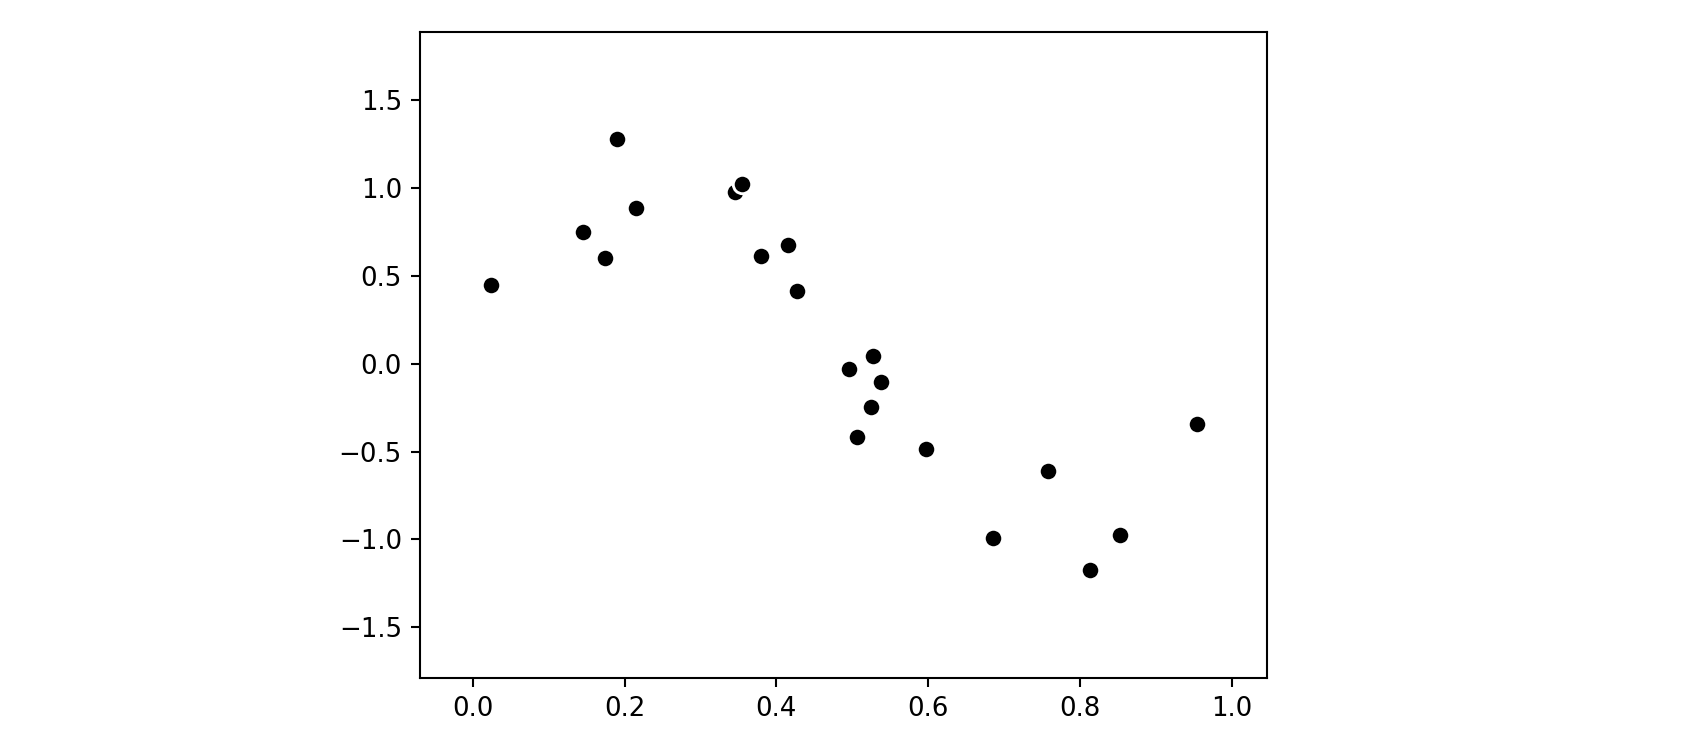

In [3]:
# load data
csvname = 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# plot everything
plotter_demo = plotter.Visualizer()
plotter_demo.plot_regression_data(x,y)

In [4]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init[1] = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [5]:
# A 3 layer network architecture
N = np.shape(x)[1]
M = np.shape(y)[1]
U_1 = 7                # number of units in layer 1
U_2 = 10               # number of units in layer 2
U_3 = 5                # number of units in layer 3

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

In [6]:
# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.1)

In [7]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [8]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

In [9]:
def activation(t):
    # tanh activation
    f = np.tanh(t)
    return f

In [10]:
def compute_features_normalized(x, inner_weights):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
        
    # loop through weights and update each layer of the network
    for W in inner_weights:
        # output of layer activation
        a = activation(np.dot(a_padded,W))
                
        ### normalize output of activation
        # compute the mean and standard deviation of the activation output distributions
        a_means = np.mean(a,axis = 0)
        a_stds = np.std(a,axis = 0)
        
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
    
    return a_padded

In [11]:
# our predict function 
def predict_normalized(x,w):     
    # feature trasnsformations
    f = compute_features_normalized(x,w[0])
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

# least squares
least_squares_normalized = lambda w: np.sum((predict_normalized(x_normed,w) - y)**2)

In [36]:
# parameters of gradient descent
alpha =  10**(-2) ;  max_its = 500; beta = 0.5; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(least_squares_normalized,w_init,alpha,max_its,beta,version = 'normalized')
cost_history_1 = [least_squares_normalized(v) for v in weight_history_1]

<IPython.core.display.Javascript object>


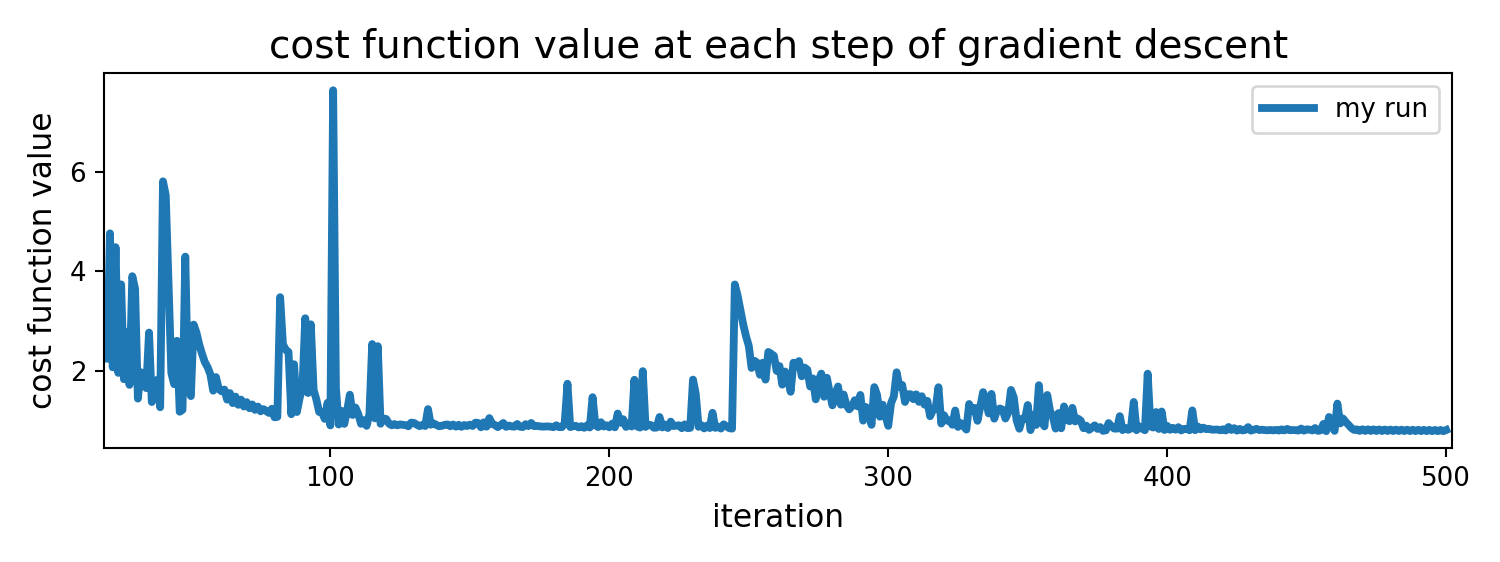

In [37]:
# plot the cost function history for our current run of gradient descent
histories = [cost_history_1]
labels = ['my run']
plotter_demo = plotter.Visualizer()
plotter_demo.compare_regression_histories(histories,start=20,labels=labels)

In [20]:
def compute_features_normalized_testing(x, inner_weights,stats):
    '''
    An adjusted normalized architecture compute function that collects network statistics as the training data
    passes through each layer, and applies them to properly normalize test data.
    '''
    # are you using this to compute stats on training data (stats empty) or to normalize testing data (stats not empty)
    switch =  'testing'
    if np.size(stats) == 0:
        switch = 'training'
        
    # if no stats given collect directly from input
    x_means = 0
    y_means = 0
    if switch == 'training':
        x_means = np.mean(x,axis = 0)
        x_stds = np.std(x,axis = 0)
        stats.append([x_means,x_stds])
    elif switch == 'testing':
        x_means = stats[0][0]
        x_stds = stats[0][1]

    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x_normed)[0],1))
    a_padded = np.concatenate((o,x_normed),axis = 1)
        
    # loop through weights and update each layer of the network
    c = 1
    for W in inner_weights:
        # output of layer activation
        a = activation(np.dot(a_padded,W))
                
        ### normalize output of activation
        a_means = 0
        a_stds = 0
        if switch == 'training':
            # compute the mean and standard deviation of the activation output distributions
            a_means = np.mean(a,axis = 0)
            a_stds = np.std(a,axis = 0)
            stats.append([a_means,a_stds])
        elif switch == 'testing':
            a_means = stats[c][0]
            a_stds = stats[c][1]
            
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
        c+=1
    
    return a_padded,stats

In [21]:
# our predict function 
def predict_testing(x,w):     
    # feature trasnsformations
    f,stats = compute_features_normalized_testing(x,w[0],training_stats)
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

In [30]:
# collect training normalization statistics for the final set of weights learned by gradient descent
best_ind = np.argmin(cost_history_1)
w1 = weight_history_1[best_ind]
a_padded,training_stats = compute_features_normalized_testing(x,w1[0],[])

<IPython.core.display.Javascript object>


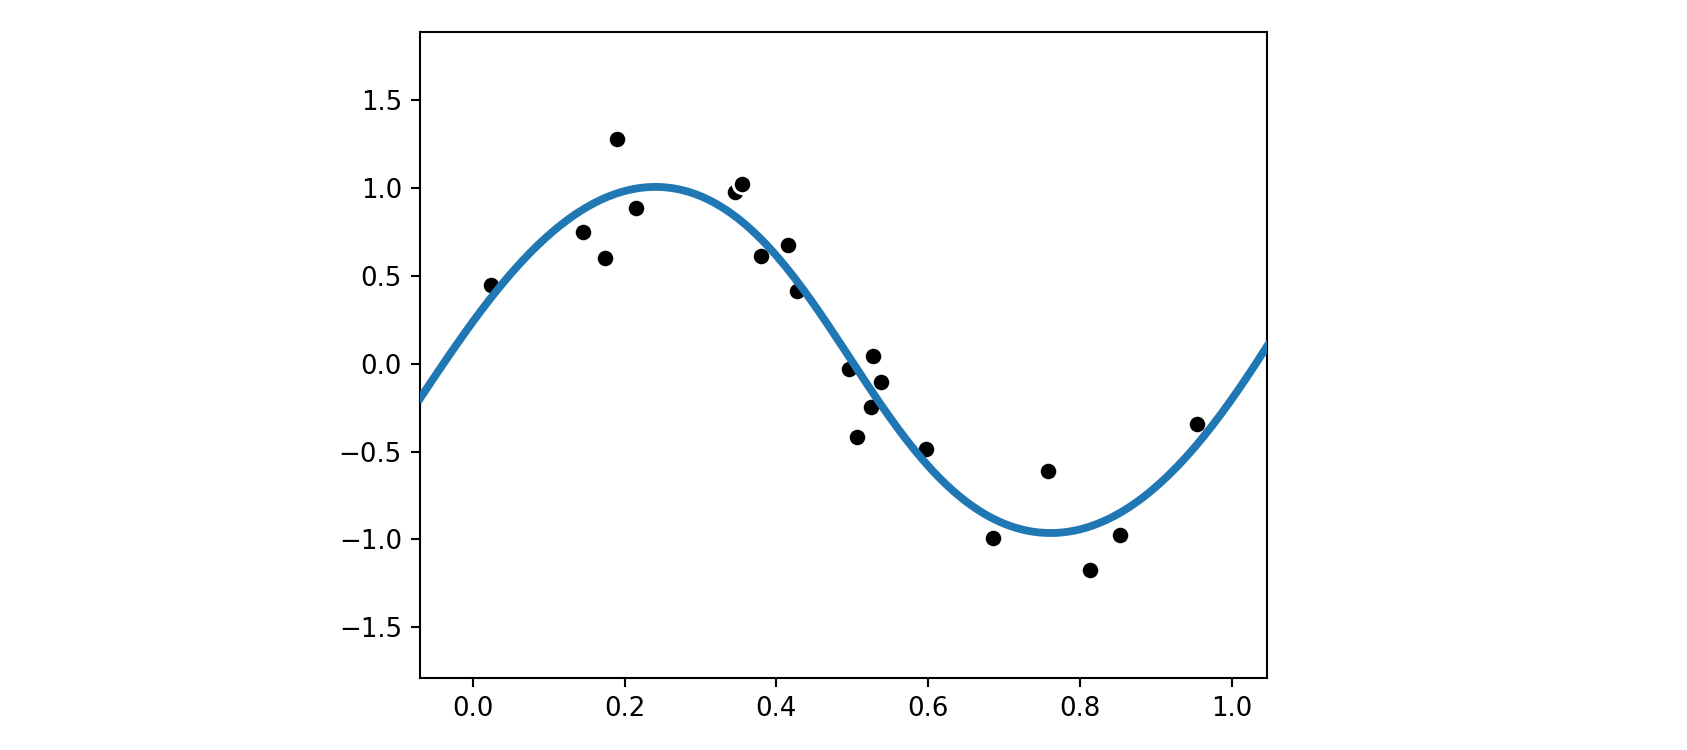

In [31]:
# compare final fits using unnormalized and normalized predictors
plotter_demo.plot_regression_data(x,y,predict = predict_testing,weights = w1)

In this excercise, I use normalization of input and activation output distributions and normalize gradient dencent. 